In [1]:
COLAB = True

if COLAB: 
  from google.colab import drive
  drive.mount('/content/drive/')
  !unzip src.zip
  !mkdir data && mkdir data/models
  !pip install audiomentations
  speech_path, save_path = "drive/MyDrive/audio-pattern", "drive/MyDrive/audio-pattern"
else:
  speech_path, save_path = "data/raw/speech", "data/processed"

Mounted at /content/drive/
Archive:  src.zip
   creating: src/
 extracting: src/__init__.py         
  inflating: src/data_processing.py  
  inflating: src/loader.py           
  inflating: src/dataset.py          
  inflating: src/models.py           
  inflating: src/utility.py          
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 5.3 MB/s 


In [2]:
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader, Augmenter
from src.models import build_train_simple, train_nn, build_nn, build_cnn, build_lstm

import seaborn as sns
sns.set_theme()

import numpy as np
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)

import warnings  
warnings.filterwarnings("ignore")

In [3]:
COMPUTE_AUGMENT = True

loader = Loader(speech_path, save_path, True, 0, -1)
orig_data, orig_labels = loader.load(False)

aug_data = None
if COMPUTE_AUGMENT:
    augmenter = Augmenter(loader)
    aug_data, _ = augmenter.augment()

In [4]:
orig_features, orig_labels = FeatureExtractor(raw_data=orig_data, labels=orig_labels, 
                                              save_path=f"{save_path}/features", 
                                              file_name="full", verbose=True, 
                                              only_mfcc=False).get_training_data(overwrite=False)

aug_features, aug_labels = FeatureExtractor(raw_data=aug_data, labels=orig_labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="full_augmented", verbose=True, 
                                            only_mfcc=False).get_training_data(overwrite=False)

orig_features_mfcc, orig_labels_mfcc = FeatureExtractor(raw_data=orig_data, labels=orig_labels, 
                                                        save_path=f"{save_path}/features", 
                                                        file_name="mfcc", verbose=True, 
                                                        only_mfcc=False).get_training_data(overwrite=False)
orig_features_mfcc = np.expand_dims(orig_features_mfcc, axis=2)

aug_features_mfcc, aug_labels_mfcc = FeatureExtractor(raw_data=aug_data, labels=orig_labels, 
                                                      save_path=f"{save_path}/features", 
                                                      file_name="mfcc_augmented", verbose=True, 
                                                      only_mfcc=False).get_training_data(overwrite=False)
aug_features_mfcc = np.expand_dims(aug_features_mfcc, axis=2)

Filename: full found on disk

Filename: full_augmented found on disk

Filename: mfcc found on disk

Filename: mfcc_augmented found on disk



In [5]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=(aug_features, aug_labels))
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

In [6]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as Dtree

k = int(len(X_train)**0.5)
scores = []
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), SVC()))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), KNN(k)))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), Dtree(max_depth=10)))

print("Simple models scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["Svc", "Knn", "Dtree"], scores)]))

Simple models scores on test:

	- Svc   : 0.581
	- Knn   : 0.421
	- Dtree : 0.391


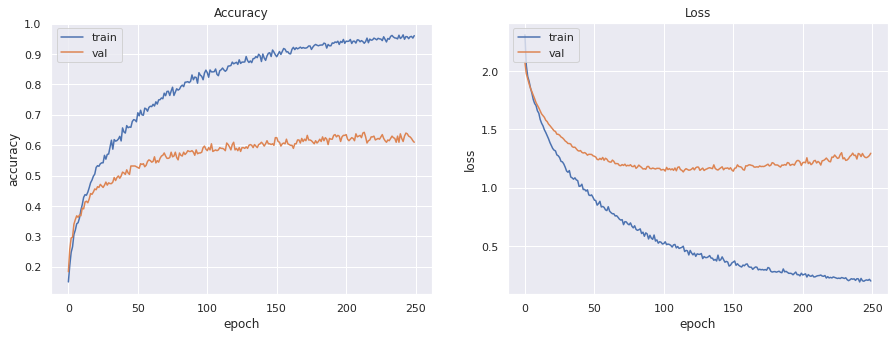

In [7]:
nn_scores = []
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_nn, epochs=250, verbose=0, plot=True)[1])

In [8]:
d = Dataset(original_data=(orig_features_mfcc, orig_labels_mfcc), augmented_data=(aug_features_mfcc, aug_labels_mfcc))
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

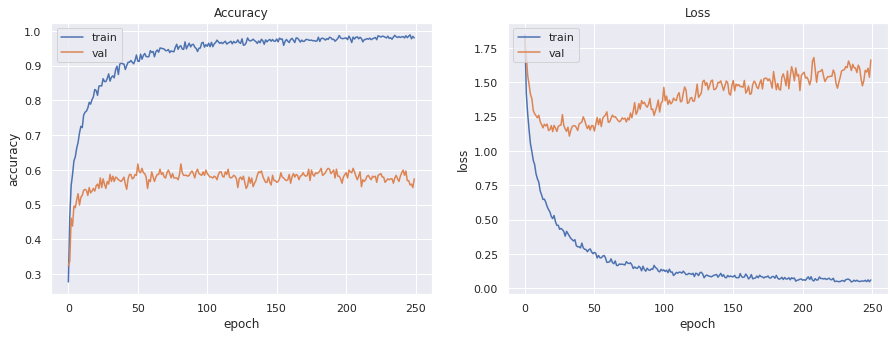

In [9]:
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_cnn, epochs=250, verbose=0, plot=True)[1])

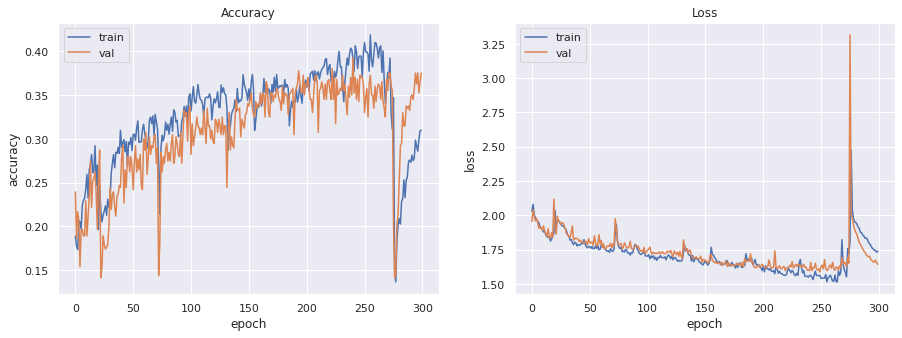

In [10]:
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_lstm, epochs=300, verbose=0, plot=True)[1])

In [11]:
print("Neural networks scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["MLP", "CNN", "LSTM"], nn_scores)]))

Neural networks scores on test:

	- MLP   : 0.659
	- CNN   : 0.671
	- LSTM  : 0.322
